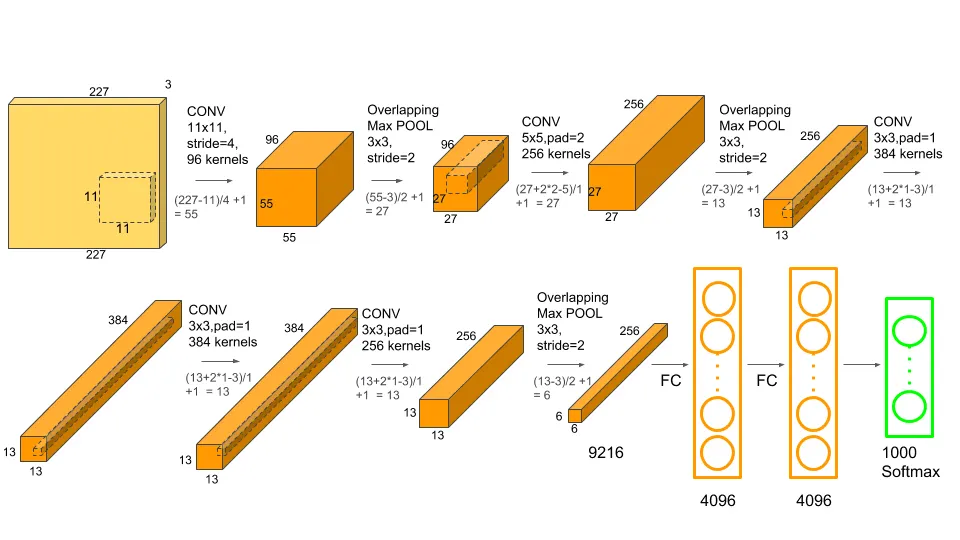

https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide

In [ ]:
!unzip '/content/drive/MyDrive/Computer_vision/Datasets/flowers_dataset.zip' -d './data'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from torchsummary import summary
import os

### Data Transformer

In [3]:
transformer = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### DataLoader

In [4]:
train_dir = '/content/data/train'
test_dir = '/content/data/valid'

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transformer)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transformer)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# next(iter(train_loader))

# for img, label in train_loader:
#   print(img)
#   print()
#   print(label)
#   break

In [7]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'daisy': 0, 'dandelion': 1}
{'daisy': 0, 'dandelion': 1}


### Dataset info

In [8]:
def dataset_info(loader, name='Dataset'):
  print(f'Dataset name: {name}')
  print(f'Total no of samples: {len(loader.dataset)}')
  print(f'Total batch size: {loader.batch_size}')
  print(f'Class Labels: {loader.dataset.class_to_idx}')

  img, lbl = next(iter(loader))
  print(f'Image size: {img.shape}')

In [12]:
dataset_info(train_loader, 'Train dataset')

Dataset name: Train dataset
Total no of samples: 1275
Total batch size: 32
Class Labels: {'daisy': 0, 'dandelion': 1}
Image size: torch.Size([32, 3, 227, 227])


In [32]:
len(train_loader)

40

# AlexNet Architecture

In [10]:
# Build Model
class AlexNet(nn.Module):
  def __init__(self, num_classes):
    super(AlexNet, self).__init__()

    self.features = nn.Sequential(
        # Conv1
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Conv2
        nn.Conv2d(96, 256, kernel_size=5, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Conv3
        nn.Conv2d(256, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        # Conv4
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        # Conv5
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, stride=2) # 6x6x256
    )

    self.classify = nn.Sequential(
        # Fully Connected layer 1
        nn.Dropout(0.5),
        nn.Linear(6*6*256, 4096),
        nn.ReLU(inplace=True),

        # Fully Connected layer 2
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        # Fully Connected layer 3
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    flatten = torch.flatten(x, 1)
    x = self.classify(flatten)

    return x

### Model instance, Loss function and Optimizers

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
model = AlexNet(num_classes=2).to(device)
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
def model_train(epochs=5):
  PATH = '/content/drive/MyDrive/Computer_vision/model'
  if not os.path.exists(PATH):
    os.makedirs(PATH, exist_ok=True)

  train_loss, train_acc = [], []

  print(f'Model run on "{device}" with {epochs} epochs.\n')
  print('='*30)

  for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    model.train()

    # Train the model using train dataset
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()

      results = model(images)
      loss = loss_function(results, labels)
      loss.backward()
      optimizer.step()

      pred_indx = torch.argmax(results, 1)
      total += labels.size(0)
      correct += (pred_indx == labels).sum().item()

      running_loss += loss.item()
    t_loss = running_loss / len(train_loader)
    t_acc = 100 * correct / total
    train_loss.append(t_loss)
    train_acc.append(t_acc)
    print(f'Epoch {epoch + 1}/{epochs}, loss: {t_loss:.6f}')
    print(f'Train accuracy: {t_acc}')

  # Save the model
  save_path = os.path.join(PATH, f'alexnet-e{epochs}.pth')
  torch.save({
      'epochs': epochs,
      'classes': train_loader.dataset.class_to_idx,
      'model_state_dict': model.state_dict()
  }, save_path)
  print('='*30)
  print()
  print(f'Model saved successfully at path: {save_path}')

In [17]:
model_train(100)

Model run on "cuda" with 100 epochs.

Epoch 1/100, loss: 51850.042909
Train accuracy: 48.86274509803921
Epoch 2/100, loss: 0.734828
Train accuracy: 52.0
Epoch 3/100, loss: 0.714641
Train accuracy: 56.705882352941174
Epoch 4/100, loss: 0.687522
Train accuracy: 56.86274509803921
Epoch 5/100, loss: 0.687439
Train accuracy: 57.1764705882353
Epoch 6/100, loss: 0.681027
Train accuracy: 58.666666666666664
Epoch 7/100, loss: 0.682410
Train accuracy: 58.19607843137255
Epoch 8/100, loss: 0.679604
Train accuracy: 58.431372549019606
Epoch 9/100, loss: 0.682994
Train accuracy: 58.509803921568626
Epoch 10/100, loss: 0.679622
Train accuracy: 58.509803921568626
Epoch 11/100, loss: 0.679976
Train accuracy: 58.509803921568626
Epoch 12/100, loss: 0.679849
Train accuracy: 58.509803921568626
Epoch 13/100, loss: 0.682606
Train accuracy: 58.509803921568626
Epoch 14/100, loss: 0.682200
Train accuracy: 58.509803921568626
Epoch 15/100, loss: 0.680560
Train accuracy: 58.509803921568626
Epoch 16/100, loss: 0.6808

### Model evalution

In [16]:
# load trained the model
checkpoint = torch.load('/content/drive/MyDrive/Computer_vision/model/alexnet-e100.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
classes = checkpoint['classes']

In [13]:
def validate():
  model.eval()
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
      results = model(images)
      class_indx = torch.argmax(results, 1)
    total += labels.size(0)
    correct += (labels==class_indx).sum().item()

  t_acc = (correct / total) * 100
  print(f'Accuracy: {t_acc:.2f}%')

In [17]:
validate()

Accuracy: 55.22%


# Model Inferencing

In [18]:
from PIL import Image

In [39]:
def prediction(image_path, transformer, device, model, class_name):
  image = Image.open(image_path).convert('RGB')
  input_batch = transformer(image).unsqueeze(0)
  input_batch = input_batch.to(device)

  model.eval()
  with torch.no_grad():
    result = model(input_batch)
    class_indx = torch.argmax(result, 1)
  class_name = list(class_name.keys())

  return class_name[class_indx]

In [40]:
img_path = '/content/data/test/daisy/34571214621_f655295459_n_jpg.rf.54272370193af45f39956b40fb692970.jpg'
res = prediction(img_path, transformer, device, model, classes)
print(f'The Image is {res}')

The Image is dandelion
